<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Saving and Loading Gluon Models

Training large models take a lot of time and it is a good idea to save the trained models to files to avoid training them again and again. There are a number of reasons to do this. For example, you might want to do inference on a machine that is different from the one where the model was trained. Sometimes model's performance on validation set decreases towards the end of the training because of overfitting. If you saved your model parameters after every epoch, at the end you can decide to use the model that performs best on the validation set. Another reason would be to train your model using one language (like Python that has a lot of tools for training) and run inference using a different language (like Scala probably because your application is built on Scala).

In this tutorial, we will learn ways to save and load Gluon models. There are two ways to save/load Gluon models:

**1. Save/load model parameters only**

Parameters of any Gluon model can be saved using the `save_parameters` and `load_parameters` method. This does not save model architecture. This method is used to save parameters of dynamic (non-hybrid) models. Model architecture cannot be saved for dynamic models because model architecture changes during execution.

**2. Save/load model parameters AND architecture**

The Model architecture of `Hybrid` models stays static and don't change during execution. Therefore both model parameters AND architecture can be saved and loaded using `export`, `imports` methods.

Let's look at the above methods in more detail. Let's start by importing the modules we'll need.

In [1]:
from __future__ import print_function

import mxnet as mx
from mxnet import np, npx, autograd, gluon
from mxnet.gluon.data.vision import transforms

import numpy as onp

## Setup: build and train a simple model

We need a trained model before we can save it to a file. So let's go ahead and build a very simple convolutional network and train it on MNIST data.

Let's define a helper function to build a LeNet model and another helper to train LeNet with MNIST.

In [2]:
# Use GPU if one exists, else use CPU
ctx = mx.gpu() if mx.context.num_gpus() else mx.cpu()

# MNIST images are 28x28. Total pixels in input layer is 28x28 = 784
num_inputs = 784
# Clasify the images into one of the 10 digits
num_outputs = 10
# 64 images in a batch
batch_size = 64

# Load the training data
train_data = gluon.data.DataLoader(gluon.data.vision.MNIST(train=True).transform_first(transforms.ToTensor()),
                                   batch_size, shuffle=True)

# Build a simple convolutional network
def build_lenet(net):    
    # First convolution
    net.add(gluon.nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    # Second convolution
    net.add(gluon.nn.Conv2D(channels=50, kernel_size=5, activation='relu'))
    net.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    # Flatten the output before the fully connected layers
    net.add(gluon.nn.Flatten())
    # First fully connected layers with 512 neurons
    net.add(gluon.nn.Dense(512, activation="relu"))
    # Second fully connected layer with as many neurons as the number of classes
    net.add(gluon.nn.Dense(num_outputs))

    return net

# Train a given model using MNIST data
def train_model(model):
    # Initialize the parameters with Xavier initializer
    model.initialize(mx.init.Xavier(), ctx=ctx)
    # Use cross entropy loss
    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
    # Use Adam optimizer
    trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': .001})

    # Train for one epoch
    for epoch in range(1):
        # Iterate through the images and labels in the training data
        for batch_num, (data, label) in enumerate(train_data):
            # get the images and labels
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            # Ask autograd to record the forward pass
            with autograd.record():
                # Run the forward pass
                output = model(data)
                # Compute the loss
                loss = softmax_cross_entropy(output, label)
            # Compute gradients
            loss.backward()
            # Update parameters
            trainer.step(data.shape[0])

            # Print loss once in a while
            if batch_num % 50 == 0:
                curr_loss = np.mean(loss).item()
                print("Epoch: %d; Batch %d; Loss %f" % (epoch, batch_num, curr_loss))

[10:47:49] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Let's build a model and train it. After training, we will save and restore this model from a file.

In [3]:
net = build_lenet(gluon.nn.Sequential())
train_model(net)

[10:47:53] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


[10:47:55] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


Epoch: 0; Batch 0; Loss 2.314028


Epoch: 0; Batch 50; Loss 0.202897


Epoch: 0; Batch 100; Loss 0.219530


Epoch: 0; Batch 150; Loss 0.153835


Epoch: 0; Batch 200; Loss 0.220375


Epoch: 0; Batch 250; Loss 0.059620


Epoch: 0; Batch 300; Loss 0.059871


Epoch: 0; Batch 350; Loss 0.125631


Epoch: 0; Batch 400; Loss 0.160359


Epoch: 0; Batch 450; Loss 0.062377


Epoch: 0; Batch 500; Loss 0.047822


Epoch: 0; Batch 550; Loss 0.036871


Epoch: 0; Batch 600; Loss 0.053252


Epoch: 0; Batch 650; Loss 0.061982


Epoch: 0; Batch 700; Loss 0.207080


Epoch: 0; Batch 750; Loss 0.019123


Epoch: 0; Batch 800; Loss 0.008956


Epoch: 0; Batch 850; Loss 0.092683


Epoch: 0; Batch 900; Loss 0.015859


<pre>Epoch: 0; Batch 0; Loss 2.288904 <!--notebook-skip-line-->
Epoch: 0; Batch 50; Loss 0.269372 <!--notebook-skip-line-->
Epoch: 0; Batch 100; Loss 0.238990 <!--notebook-skip-line-->
Epoch: 0; Batch 150; Loss 0.320592 <!--notebook-skip-line-->
Epoch: 0; Batch 200; Loss 0.048619 <!--notebook-skip-line-->
Epoch: 0; Batch 250; Loss 0.121555 <!--notebook-skip-line-->
Epoch: 0; Batch 300; Loss 0.083645 <!--notebook-skip-line-->
Epoch: 0; Batch 350; Loss 0.040627 <!--notebook-skip-line-->
Epoch: 0; Batch 400; Loss 0.195946 <!--notebook-skip-line-->
Epoch: 0; Batch 450; Loss 0.155514 <!--notebook-skip-line-->
Epoch: 0; Batch 500; Loss 0.031762 <!--notebook-skip-line-->
Epoch: 0; Batch 550; Loss 0.056516 <!--notebook-skip-line-->
Epoch: 0; Batch 600; Loss 0.095174 <!--notebook-skip-line-->
Epoch: 0; Batch 650; Loss 0.054901 <!--notebook-skip-line-->
Epoch: 0; Batch 700; Loss 0.030067 <!--notebook-skip-line-->
Epoch: 0; Batch 750; Loss 0.102611 <!--notebook-skip-line-->
Epoch: 0; Batch 800; Loss 0.010036 <!--notebook-skip-line-->
Epoch: 0; Batch 850; Loss 0.051853 <!--notebook-skip-line-->
Epoch: 0; Batch 900; Loss 0.008402 <!--notebook-skip-line-->
</pre> <!--notebook-skip-line-->

## Saving model parameters to file

Okay, we now have a model (`net`) that we can save to a file. Let's save the parameters of this model to a file using the `save_parameters` function.

In [4]:
file_name = "net.params"
net.save_parameters(file_name)

We have successfully saved the parameters of the model into a file.

## Loading model parameters from file

Let's now create a network with the parameters we saved into the file. We build the network again using the helper first and then load the weights from the file we saved using the `load_parameters` function.

In [5]:
new_net = build_lenet(gluon.nn.Sequential())
new_net.load_parameters(file_name, ctx=ctx)

Note that to do this, we need the definition of the network as Python code. If we want to recreate this network on a different machine using the saved weights, we need the same Python code (`build_lenet`) that created the network to create the `new_net` object shown above. This means Python code needs to be copied over to any machine where we want to run this network.

If our network is [Hybrid](./hybridize.ipynb), we can even save the network architecture into files and we won't need the network definition in a Python file to load the network. We'll see how to do it in the next section.

Let's test the model we just loaded from file.

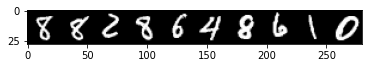

Model predictions:  [8 8 2 8 6 4 8 6 1 0]


In [6]:
import matplotlib.pyplot as plt

def verify_loaded_model(net):
    """Run inference using ten random images.
    Print both input and output of the model"""

    def transform(data, label):
        return data.astype(np.float32)/255, label.astype(np.float32)

    # Load ten random images from the test dataset
    sample_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False).transform(transform),
                                  10, shuffle=True)

    for data, label in sample_data:

        # Display the images
        img = np.transpose(data, (1,0,2,3))
        img = npx.reshape(img, (28,10*28,1))
        imtiles = np.tile(img, (1,1,3))
        plt.imshow(imtiles.asnumpy())
        plt.show()

        # Display the predictions
        data = np.transpose(data, (0, 3, 1, 2))
        out = net(data.as_in_ctx(ctx))
        predictions = np.argmax(out, axis=1)
        print('Model predictions: ', predictions.asnumpy())

        break

verify_loaded_model(new_net)

![Model inputs mnist in 1](https://raw.githubusercontent.com/indhub/web-data/4a9c100aa996df3dff0e7f493029d411c2b526c3/mxnet/tutorials/gluon/save_load_params/mnist_in_1.png) <!--notebook-skip-line-->

Model predictions:  [1. 1. 4. 5. 0. 5. 7. 0. 3. 6.] <!--notebook-skip-line-->

## Saving model parameters AND architecture to file

[Hybrid](./hybridize.ipynb) models can be serialized as JSON files using the `export` function. Once serialized, these models can be loaded from other language bindings like C++ or Scala for faster inference or inference in different environments.

Note that the network we created above is not a Hybrid network and therefore cannot be serialized into a JSON file. So, let's create a Hybrid version of the same network and train it.

In [7]:
net = build_lenet(gluon.nn.HybridSequential())
net.hybridize()
train_model(net)

Epoch: 0; Batch 0; Loss 2.305883


Epoch: 0; Batch 50; Loss 0.366352


Epoch: 0; Batch 100; Loss 0.185870


Epoch: 0; Batch 150; Loss 0.073051


Epoch: 0; Batch 200; Loss 0.246617


Epoch: 0; Batch 250; Loss 0.045916


Epoch: 0; Batch 300; Loss 0.068754


Epoch: 0; Batch 350; Loss 0.208423


Epoch: 0; Batch 400; Loss 0.024758


Epoch: 0; Batch 450; Loss 0.055754


Epoch: 0; Batch 500; Loss 0.229517


Epoch: 0; Batch 550; Loss 0.060816


Epoch: 0; Batch 600; Loss 0.018763


Epoch: 0; Batch 650; Loss 0.015921


Epoch: 0; Batch 700; Loss 0.022501


Epoch: 0; Batch 750; Loss 0.034459


Epoch: 0; Batch 800; Loss 0.037060


Epoch: 0; Batch 850; Loss 0.015754


Epoch: 0; Batch 900; Loss 0.074327


<pre>Epoch: 0; Batch 0; Loss 2.323284 <!--notebook-skip-line-->
Epoch: 0; Batch 50; Loss 0.444733 <!--notebook-skip-line-->
Epoch: 0; Batch 100; Loss 0.103407 <!--notebook-skip-line-->
Epoch: 0; Batch 150; Loss 0.166772 <!--notebook-skip-line-->
Epoch: 0; Batch 200; Loss 0.227569 <!--notebook-skip-line-->
Epoch: 0; Batch 250; Loss 0.069515 <!--notebook-skip-line-->
Epoch: 0; Batch 300; Loss 0.074086 <!--notebook-skip-line-->
Epoch: 0; Batch 350; Loss 0.074382 <!--notebook-skip-line-->
Epoch: 0; Batch 400; Loss 0.026569 <!--notebook-skip-line-->
Epoch: 0; Batch 450; Loss 0.097248 <!--notebook-skip-line-->
Epoch: 0; Batch 500; Loss 0.059895 <!--notebook-skip-line-->
Epoch: 0; Batch 550; Loss 0.053194 <!--notebook-skip-line-->
Epoch: 0; Batch 600; Loss 0.076294 <!--notebook-skip-line-->
Epoch: 0; Batch 650; Loss 0.047274 <!--notebook-skip-line-->
Epoch: 0; Batch 700; Loss 0.007898 <!--notebook-skip-line-->
Epoch: 0; Batch 750; Loss 0.039478 <!--notebook-skip-line-->
Epoch: 0; Batch 800; Loss 0.031342 <!--notebook-skip-line-->
Epoch: 0; Batch 850; Loss 0.059289 <!--notebook-skip-line-->
Epoch: 0; Batch 900; Loss 0.037809 <!--notebook-skip-line-->
</pre> <!--notebook-skip-line-->

We now have a trained hybrid network. This can be exported into files using the `export` function. The `export` function will export the model architecture into a `.json` file and model parameters into a `.params` file.

In [8]:
net.export("lenet", epoch=1)

('lenet-symbol.json', 'lenet-0001.params')

`export` in this case creates `lenet-symbol.json` and `lenet-0001.params` in the current directory.

## Loading model parameters AND architecture from file


### From Python

Serialized Hybrid networks (saved as .JSON and .params file) can be loaded and used inside Python frontend using `gluon.nn.SymbolBlock`. To demonstrate that, let's load the network we serialized above.

In [9]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    deserialized_net = gluon.nn.SymbolBlock.imports("lenet-symbol.json", ['data'], "lenet-0001.params", ctx=ctx)

`deserialized_net` now contains the network we deserialized from files. Let's test the deserialized network to make sure it works.

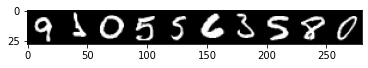

Model predictions:  [9 1 0 5 5 6 3 5 8 0]


In [10]:
verify_loaded_model(deserialized_net)

![Model inputs mnist in 2](https://raw.githubusercontent.com/indhub/web-data/4a9c100aa996df3dff0e7f493029d411c2b526c3/mxnet/tutorials/gluon/save_load_params/mnist_in_2.png) <!--notebook-skip-line-->

Model predictions:  [4. 8. 0. 1. 5. 5. 8. 8. 1. 9.] <!--notebook-skip-line-->

That's all! We learned how to save and load Gluon networks from files. Parameters of any Gluon network can be persisted into files. For hybrid networks, both the architecture of the network and the parameters can be saved to and loaded from files.